People always look at a player's performance over the past season or several as an indicator of his skills. But how accurate is it actually at predicting the same player's performance in the new season? How many seasons back should be look? And how much the player's team can affect it? Those are the main topics this notebook aims to research.

At first, we are going to test out a simple model where we are only interested in the points (goals + assists) and, therefore, only the skaters. If the model shows any promising result, we can attempt expanding it to the other key performance indicators as well.

In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# We do not need the whole dataframe.
columns_read = ['Profile', 'Player', 'Season', 'Team', 'Year', 'Games', 'Points', 'Icetime_game_seconds']
source_data = pd.read_csv('../data/players/skaters_season.csv', usecols=columns_read)
source_data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283


We will definitely need the total time on ice over the season. After all, two players might be equally skilled but one of them simply gets much more icetime and thus gets more points. What we are going to use is not the points over the season but really a standartised amount of points over a certain interval. For ease of browse, let us set the interval as 60 minutes (standard match length) the same as with goalies.

In [2]:
data = source_data.copy()
data['Icetime'] = data['Games'] * data['Icetime_game_seconds'] / 3600
data['Points_average'] = data['Points'] / data['Icetime']
data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds,Icetime,Points_average
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417,1.505833,0.664084
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375,1.250000,0.000000
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360,0.800000,0.000000
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583,3.238889,1.234991
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283,0.864722,1.156441


Since we are using averages we need to ensure that all players have participated at a certain bare mininum during the season. This could be accounted for in two ways, based off either games played, points scored or icetime recorded. For now, icetime and points seem like a good choice. Let us set the minimum requirement at 3 hours and 5 points.

On a related note, let us drop all playoff seasons from the data. Not only they tend to be fairly short and would be mostly sorted out based on the icetime required, but the playoff matches tend to behave somewhat differently than the regular season.

In [3]:
data = data[data['Season'] == 'Regular season']
data = data[data['Icetime'] >= 5]
data = data[data['Points'] >= 10]

In [4]:
data.describe()

,Games,Points,Icetime_game_seconds,Icetime,Points_average
count,5059.000000,5059.000000,5059.000000,5059.000000,5059.000000
mean,47.664954,21.569678,1001.002174,13.316518,1.646922
std,9.031108,10.713293,175.036520,3.684514,0.663090
min,16.000000,10.000000,490.000000,5.020000,0.447094
25%,42.000000,13.000000,877.000000,10.653056,1.140005
50%,50.000000,19.000000,994.000000,13.287500,1.556709
75%,54.000000,27.000000,1117.000000,15.841528,2.037704
max,63.000000,85.000000,1720.000000,26.500000,5.162264


Important note! We have some rows where Team is specified as "Summary". That is the case when a player has changed his team during the season, so he ends up having a separate row of statistics for both teams and for them combined.

Ideally, we want to take such cases into account but it present problems of its own. If we keep just the summary, we cannot include teams in our model. If we keep the statistics for each team separately, the rows might fail the icetime requirement even if the player had enough icetime that season to get included. For now, let us go with the latter approach.

In [5]:
data = data[data['Team'] != 'Summary']

We are going to first try predicting based off the latest two seasons that player has participated in. Important note - those seasons are not necessarily the last ones as a player could not participate in some seasons or not participate enough to be included in our analysis. And since we need the values for at least the current and two latest seasons for each player, players with less than 3 seasons in the data have to be dropped altogether.

In [6]:
data = data.groupby('Profile').filter(lambda x: len(x) > 2)

In [7]:
data = data.groupby('Team').filter(lambda x: len(x) > 50)

In [8]:
# To avoid typing column lists manually.
data.columns

Index(['Profile', 'Player', 'Season', 'Year', 'Team', 'Games', 'Points',
       'Icetime_game_seconds', 'Icetime', 'Points_average'],
      dtype='object')

In [9]:
# We can drop all unnecessary columns now.
drop_list = ['Season', 'Games', 'Points', 'Icetime_game_seconds', 'Icetime']
data.drop(drop_list, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,Profile,Player,Year,Team,Points_average
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,Lokomotiv (Yaroslavl),1.081731
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262
2,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,Lokomotiv (Yaroslavl),0.968610
3,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),1.811594
4,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514


We now need to add the year/team/points data from the past two years to the dataframe. The simplest way to do this is by adding shifted versions of the same columns with different column names. However, a row above does not necessarily contain the data for the same player. To account for that, we are going to include both past profile and player name in the output dataframe and check that they remain the same.

In [10]:
# The rows are going to be shifted down.
# All columns are getting a T_ prefix indicating their timeshift relative to the current period.
new_columns = ['New_Profile', 'New_Player', 'New_Year', 'New_Team', 'New_Points']
old_columns = ['Old_Profile', 'Old_Player', 'Old_Year', 'Old_Team', 'Old_Points']

data.columns = new_columns
data[old_columns] = data[new_columns].shift(-1)
data.head()

,New_Profile,New_Player,New_Year,New_Team,New_Points,Old_Profile,Old_Player,Old_Year,Old_Team,Old_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,Lokomotiv (Yaroslavl),1.081731,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,Lokomotiv (Yaroslavl),0.968610
2,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,Lokomotiv (Yaroslavl),0.968610,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),1.811594
3,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),1.811594,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514
4,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,CSKA (Moscow),0.798509


In [11]:
data.tail(5)

,New_Profile,New_Player,New_Year,New_Team,New_Points,Old_Profile,Old_Player,Old_Year,Old_Team,Old_Points
3501,https://en.khl.ru/players/17538/,Patrik Zackrisson,2011/2012,Atlant (Moscow Region),1.236650,https://en.khl.ru/players/23355/,Denis Zernov,2020/2021,Avangard (Omsk),2.456499
3502,https://en.khl.ru/players/23355/,Denis Zernov,2020/2021,Avangard (Omsk),2.456499,https://en.khl.ru/players/23355/,Denis Zernov,2018/2019,Avangard (Omsk),1.911462
3503,https://en.khl.ru/players/23355/,Denis Zernov,2018/2019,Avangard (Omsk),1.911462,https://en.khl.ru/players/23355/,Denis Zernov,2017/2018,Lada (Togliatti),1.615499
3504,https://en.khl.ru/players/23355/,Denis Zernov,2017/2018,Lada (Togliatti),1.615499,https://en.khl.ru/players/23355/,Denis Zernov,2016/2017,Lada (Togliatti),1.487272
3505,https://en.khl.ru/players/23355/,Denis Zernov,2016/2017,Lada (Togliatti),1.487272,NaN,NaN,NaN,NaN,NaN


We are also encountering another issue here. Since some players have changed teams during the season, we are getting observations where the last time period our of three would be season 2009/2010. And, what is worse, some players have even played for three teams in season 2008/2009. Not only do those seasons have few observations, they are not representative as only the players who have changed teams can have either of their seasons as the latest of the three. Therefore, let us drop them.

In [12]:
# Now dropping the rows which contain data for different players in them.
data = data[data['New_Profile'] == data['Old_Profile']]
data = data[data['New_Year'] != '2008/2009']
data.reset_index(drop=True, inplace=True)
data.head()

,New_Profile,New_Player,New_Year,New_Team,New_Points,Old_Profile,Old_Player,Old_Year,Old_Team,Old_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,Lokomotiv (Yaroslavl),1.081731,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,Lokomotiv (Yaroslavl),0.968610
2,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),1.811594,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514
3,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,CSKA (Moscow),0.798509
4,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,CSKA (Moscow),0.798509,https://en.khl.ru/players/14763/,Sergei Andronov,2015/2016,CSKA (Moscow),0.952822


In [13]:
# Everything seems in order, we can drop the duplicate columns now.
data.drop(['Old_Profile', 'Old_Player'], axis=1, inplace=True)
data.head()

,New_Profile,New_Player,New_Year,New_Team,New_Points,Old_Year,Old_Team,Old_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,Lokomotiv (Yaroslavl),1.081731,2009/2010,Lokomotiv (Yaroslavl),0.965262
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),0.965262,2008/2009,Lokomotiv (Yaroslavl),0.968610
2,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),1.811594,2018/2019,CSKA (Moscow),1.013514
3,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),1.013514,2016/2017,CSKA (Moscow),0.798509
4,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,CSKA (Moscow),0.798509,2015/2016,CSKA (Moscow),0.952822


In [14]:
data['Point_ratio'] = data['New_Points'] / data['Old_Points']
data.drop(['New_Points', 'Old_Points', 'Old_Year'], axis=1, inplace=True)
data.head()

,New_Profile,New_Player,New_Year,New_Team,Old_Team,Point_ratio
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,Lokomotiv (Yaroslavl),Lokomotiv (Yaroslavl),1.120660
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,Lokomotiv (Yaroslavl),Lokomotiv (Yaroslavl),0.996544
2,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,CSKA (Moscow),CSKA (Moscow),1.787440
3,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,CSKA (Moscow),CSKA (Moscow),1.269257
4,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,CSKA (Moscow),CSKA (Moscow),0.838047


In [15]:
# We can now get dummies for our years and teams.
dummies = data.copy()
dummies.drop(['New_Profile', 'New_Player'], axis=1, inplace=True)
dummies.columns = ['Year', 'Team', 'Old_Team', 'Point_ratio']
dummies = pd.get_dummies(dummies, drop_first=True)
dummies.head()

,Point_ratio,Year_2010/2011,Year_2011/2012,Year_2012/2013,Year_2013/2014,Year_2014/2015,Year_2015/2016,Year_2016/2017,Year_2017/2018,Year_2018/2019,Year_2019/2020,Year_2020/2021,Team_Ak Bars (Kazan),Team_Amur (Khabarovsk),Team_Atlant (Moscow Region),Team_Avangard (Omsk),Team_Avtomobilist (Ekaterinburg),Team_Barys (Nur-Sultan),Team_CSKA (Moscow),Team_Dinamo (Minsk),Team_Dinamo (Riga),Team_Dynamo (Moscow),Team_Jokerit (Helsinki),Team_Lada (Togliatti),Team_Lokomotiv (Yaroslavl),Team_Metallurg (Magnitogorsk),Team_Metallurg (Novokuznetsk),Team_Neftekhimik (Nizhnekamsk),Team_SKA (Saint Petersburg),Team_Salavat Yulaev (Ufa),Team_Severstal (Cherepovets),Team_Sibir (Novosibirsk Region),Team_Slovan (Bratislava),Team_Sochi (Sochi),Team_Spartak (Moscow),Team_Torpedo (Nizhny Novgorod Region),Team_Traktor (Chelyabinsk),Team_Ugra (Khanty-Mansiysk),Team_Vityaz (Moscow Region),Old_Team_Ak Bars (Kazan),Old_Team_Amur (Khabarovsk),Old_Team_Atlant (Moscow Region),Old_Team_Avangard (Omsk),Old_Team_Avtomobilist (Ekaterinburg),Old_Team_Barys (Nur-Sultan),Old_Team_CSKA (Moscow),Old_Team_Dinamo (Minsk),Old_Team_Dinamo (Riga),Old_Team_Dynamo (Moscow),Old_Team_Jokerit (Helsinki),Old_Team_Lada (Togliatti),Old_Team_Lokomotiv (Yaroslavl),Old_Team_Metallurg (Magnitogorsk),Old_Team_Metallurg (Novokuznetsk),Old_Team_Neftekhimik (Nizhnekamsk),Old_Team_SKA (Saint Petersburg),Old_Team_Salavat Yulaev (Ufa),Old_Team_Severstal (Cherepovets),Old_Team_Sibir (Novosibirsk Region),Old_Team_Slovan (Bratislava),Old_Team_Sochi (Sochi),Old_Team_Spartak (Moscow),Old_Team_Torpedo (Nizhny Novgorod Region),Old_Team_Traktor (Chelyabinsk),Old_Team_Ugra (Khanty-Mansiysk),Old_Team_Vityaz (Moscow Region)
0,1.120660,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.996544,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.787440,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.269257,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.838047,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can now try fitting Machine Learning models on that prepared data. Let us first start with a simple linear regression before moving to random forests and boosted trees.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# We are trying to predict how many points a player gets this new season based off everything else.
y = dummies['Point_ratio'].copy()
X = dummies.drop('Point_ratio', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
linear = LinearRegression(n_jobs=-1)

In [20]:
linear.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [21]:
y_pred = linear.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
y_train.mean()

1.033948897000186

In [24]:
y_test.mean()

1.0273493080867466

In [25]:
y_pred.mean()

1.0374115339177554

In [26]:
mean_squared_error(y_test, y_pred)

0.13411752368943836

In [27]:
mean_absolute_error(y_test, y_pred)

0.2866163326864354

In [28]:
r2_score(y_test, y_pred)

-0.04058657336082594

In [29]:
# Getting coefficients in a more readable form.
linear_coef = pd.DataFrame(zip(X.columns, linear.coef_))
linear_coef.columns = ['Feature', 'Coefficient']
linear_coef

,Feature,Coefficient
0,Year_2010/2011,0.065212
1,Year_2011/2012,0.035912
2,Year_2012/2013,-0.002416
3,Year_2013/2014,-0.005482
4,Year_2014/2015,0.077340
5,Year_2015/2016,-0.024668
6,Year_2016/2017,0.056868
7,Year_2017/2018,0.087536
8,Year_2018/2019,-0.033725
9,Year_2019/2020,0.008244


We can still improve on the way coefficients are stored. After all, we have 3 sets of coefficients for three different time periods. Why not give each period its own column?

In [30]:
# Splitting the dataframe into three.
Newcoef = linear_coef[linear_coef['Feature'].str.startswith('New')].copy().reset_index(drop=True)
Old_coef = linear_coef[linear_coef['Feature'].str.startswith('Old_')].copy().reset_index(drop=True)
T2_coef = linear_coef[linear_coef['Feature'].str.startswith('T2_')].copy().reset_index(drop=True)

# Removing the year indicators from feature names.
Newcoef['Feature'].replace({'New': ''}, inplace=True, regex=True)
Old_coef['Feature'].replace({'Old_': ''}, inplace=True, regex=True)
T2_coef['Feature'].replace({'T2_': ''}, inplace=True, regex=True)

# Changing column names for coefficients.
Newcoef.columns = ['Feature', 'Period_0']
Old_coef.columns = ['Feature', 'Period_1']
T2_coef.columns = ['Feature', 'Period_2']

# Final dataframe.
linear_coef = Newcoef.merge(Old_coef, how='outer', on='Feature').merge(T2_coef, how='outer', on='Feature')
linear_coef

,Period_0,Feature,Period_1,Period_2
0,NaN,Team_Ak Bars (Kazan),0.077580,NaN
1,NaN,Team_Amur (Khabarovsk),0.122367,NaN
2,NaN,Team_Atlant (Moscow Region),-0.073384,NaN
3,NaN,Team_Avangard (Omsk),0.028464,NaN
4,NaN,Team_Avtomobilist (Ekaterinburg),0.102077,NaN
5,NaN,Team_Barys (Nur-Sultan),-0.023848,NaN
6,NaN,Team_CSKA (Moscow),0.054053,NaN
7,NaN,Team_Dinamo (Minsk),-0.017136,NaN
8,NaN,Team_Dinamo (Riga),0.065689,NaN
9,NaN,Team_Dynamo (Moscow),0.031367,NaN


We will need to rearrange the columns for sure. More importantly, why are Period 1 year features' coefficients so high? Something is definitely not right in here.

In [31]:
import matplotlib.pyplot as plt

[]

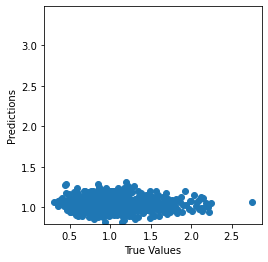

In [32]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.plot()